## 1. Import Libraries and Data

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import OrderedDict
from dataloaders.base import MNIST
from dataloaders.datasetGen import PermutationGen
from agents.regularization import SI, EWC_online
from agents.default import NormalNN

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
random.seed(42)
np.random.seed(42)

%matplotlib inline

In [4]:
if not os.path.exists('outputs'):
    os.mkdir('outputs')

train_dataset, val_dataset = MNIST(r'../data/')
train_dataset_splits, val_dataset_splits, task_output_space = PermutationGen(train_dataset, val_dataset, num_permutations=10)

Text(0.5, 1.0, 'Permuted MNIST')

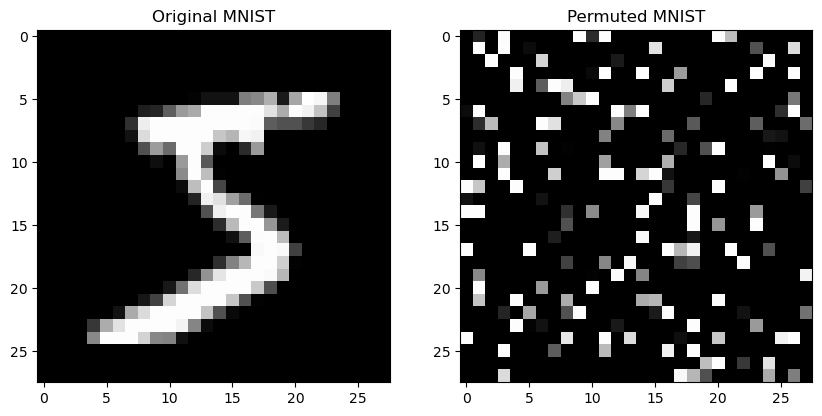

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(train_dataset_splits['1'][0][0].reshape(28, 28), cmap='gray')
axs[0].set_title('Original MNIST')
axs[1].imshow(train_dataset_splits['2'][0][0].reshape(28, 28), cmap='gray')
axs[1].set_title('Permuted MNIST')

## 2. Construct the model

In [6]:
# Hyperparameters
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 2000
reg_coef = 0.1
damping_factor = 0.1

# Optimization params
batch_size = 256
epochs_per_task = 20

# Reset optimizer after each age
reset_optimizer = False

### 2.1. SGD

In [5]:
agent_config_sgd = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': 0,
    'model_type': 'mlp',
    'model_name': 'MLP2000_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_sgd = NormalNN(agent_config_sgd)

### 2.2. SGD with Dropout

In [6]:
agent_config_sgd_dropout = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': 0,
    'model_type': 'mlp',
    'model_name': 'MLPDropout2000_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_sgd_dropout = NormalNN(agent_config_sgd_dropout)

### 2.3. EWC

In [7]:
agent_config_ewc = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': reg_coef,
    'model_type': 'mlp',
    'model_name': 'MLP2000_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_ewc = EWC_online(agent_config_ewc)

### 2.4. SI

In [11]:
agent_config_si = {
    'epochs': epochs_per_task,
    'lr': 1e-3,
    'weight_decay': 0,
    'reg_coef': reg_coef,
    'model_type': 'mlp',
    'model_name': 'MLP2000_MNIST',
    'out_dim': task_output_space,
    'model_weights': None,
    'print_freq': 100,
    'gpu': True
}

agent_si = SI(agent_config_si)
agent_si.damping_factor = damping_factor

## 3. Training

### 3.1. SGD

In [9]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table_sgd = OrderedDict()

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table_sgd[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent_sgd.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table_sgd[val_name][train_name] = agent_sgd.validation(val_loader)

====================== 1 =======================
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/235]	2.6065 (2.6065)	0.0750 (0.0750)	2.302 (2.302)	0.15 (0.15)
[100/235]	0.0498 (0.0728)	0.0303 (0.0311)	0.123 (0.354)	0.96 (0.90)
[200/235]	0.0515 (0.0620)	0.0295 (0.0311)	0.112 (0.248)	0.96 (0.93)
Train Acc: 0.931
Validation: Time: 1.874 Acc: 0.969
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0850 (0.0850)	0.0380 (0.0380)	0.064 (0.064)	0.98 (0.98)
[100/235]	0.0502 (0.0530)	0.0304 (0.0320)	0.040 (0.075)	0.98 (0.98)
[200/235]	0.0539 (0.0525)	0.0320 (0.0313)	0.066 (0.075)	0.98 (0.98)
Train Acc: 0.977
Validation: Time: 1.665 Acc: 0.972
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0889 (0.0889)	0.0409 (0.0409)	0.081 (0.081)	0.98 (0.98)
[100/235]	0.0499 (0.0528)	0.0293 (0.0322)	0.058 (0.047)	0.99 (0.99)
[200/235]	0.0638 (0.0553)	0.0357 (0.0336)	0.072 (0.048)	0.98 (0.99)
Train Acc: 0.985
Validation: Time: 1.873 Acc: 0.973
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0868 (0.0868)	0.038

In [13]:
with open('outputs/acc_table_sgd.pkl', 'wb') as f:
    pickle.dump(acc_table_sgd, f)

### 3.2. SGD with Dropout

In [9]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table_sgd_dropout = OrderedDict()

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table_sgd_dropout[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent_sgd_dropout.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table_sgd_dropout[val_name][train_name] = agent_sgd_dropout.validation(val_loader)

====================== 1 =======================
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/235]	2.4038 (2.4038)	0.1334 (0.1334)	2.299 (2.299)	0.10 (0.10)
[100/235]	0.0510 (0.0770)	0.0310 (0.0353)	0.199 (0.469)	0.94 (0.86)
[200/235]	0.0531 (0.0679)	0.0298 (0.0358)	0.161 (0.344)	0.96 (0.89)
Train Acc: 0.901
Validation: Time: 2.072 Acc: 0.962
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/235]	0.1039 (0.1039)	0.0548 (0.0548)	0.223 (0.223)	0.91 (0.91)
[100/235]	0.2160 (0.0852)	0.1580 (0.0571)	0.129 (0.155)	0.96 (0.95)
[200/235]	0.1153 (0.1266)	0.0694 (0.0887)	0.144 (0.150)	0.95 (0.95)
Train Acc: 0.954
Validation: Time: 3.103 Acc: 0.976
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/235]	0.1012 (0.1012)	0.0492 (0.0492)	0.129 (0.129)	0.97 (0.97)
[100/235]	0.0510 (0.0669)	0.0310 (0.0398)	0.108 (0.117)	0.97 (0.96)
[200/235]	0.0639 (0.0646)	0.0325 (0.0395)	0.188 (0.117)	0.96 (0.96)
Train Acc: 0.964
Validation: Time: 2.036 Acc: 0.976
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0990 (0.0990)	0.050

In [10]:
with open('outputs/acc_table_sgd_dropout.pkl', 'wb') as f:
    pickle.dump(acc_table_sgd_dropout, f)

### 3.3. EWC

In [8]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table_ewc = OrderedDict()

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table_ewc[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent_ewc.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table_ewc[val_name][train_name] = agent_ewc.validation(val_loader)

====================== 1 =======================
#reg_term: 0
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/235]	1.4377 (1.4377)	0.0570 (0.0570)	2.304 (2.304)	0.13 (0.13)
[100/235]	0.0536 (0.0635)	0.0341 (0.0331)	0.156 (0.362)	0.96 (0.89)
[200/235]	0.0597 (0.0588)	0.0352 (0.0332)	0.148 (0.249)	0.96 (0.92)
Train Acc: 0.931
Validation: Time: 1.579 Acc: 0.969
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0950 (0.0950)	0.0474 (0.0474)	0.066 (0.066)	0.98 (0.98)
[100/235]	0.0495 (0.0518)	0.0294 (0.0312)	0.094 (0.084)	0.97 (0.97)
[200/235]	0.0521 (0.0522)	0.0310 (0.0313)	0.066 (0.079)	0.98 (0.98)
Train Acc: 0.975
Validation: Time: 1.561 Acc: 0.978
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0929 (0.0929)	0.0469 (0.0469)	0.039 (0.039)	0.99 (0.99)
[100/235]	0.0545 (0.0515)	0.0353 (0.0313)	0.037 (0.048)	0.98 (0.98)
[200/235]	0.0520 (0.0521)	0.0297 (0.0317)	0.080 (0.050)	0.97 (0.98)
Train Acc: 0.984
Validation: Time: 1.631 Acc: 0.976
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/235]	0.1088 (

In [9]:
with open('outputs/acc_table_ewc.pkl', 'wb') as f:
    pickle.dump(acc_table_ewc, f)

### 3.4. SI

In [12]:
# Incremental training
task_names = list(task_output_space.keys())
acc_table_si = OrderedDict()

for i in range(len(task_names)):
    task_name = task_names[i]
    acc_table_si[task_name] = OrderedDict()

for i in range(len(task_names)):
    train_name = task_names[i]
    print('======================', train_name, '=======================')

    train_loader = torch.utils.data.DataLoader(train_dataset_splits[train_name], 
                                               batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset_splits[train_name], 
                                             batch_size=batch_size, shuffle=False)

    # Learn
    agent_si.learn_batch(train_loader, val_loader)

    # Evaluate
    for j in range(len(task_names)):
        val_name = task_names[j]
        print('validation split name:', val_name)
        val_data = val_dataset_splits[val_name]
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
        acc_table_si[val_name][train_name] = agent_si.validation(val_loader)

====================== 1 =======================
#reg_term: 0
Epoch: 0
Itr		Time		  Data		  Loss		Acc
[0/235]	0.2728 (0.2728)	0.0668 (0.0668)	2.300 (2.300)	0.07 (0.07)
[100/235]	0.0713 (0.0670)	0.0412 (0.0392)	0.178 (0.362)	0.97 (0.89)
[200/235]	0.0723 (0.0688)	0.0412 (0.0395)	0.119 (0.251)	0.96 (0.93)
Train Acc: 0.931
Validation: Time: 1.675 Acc: 0.971
Epoch: 1
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0813 (0.0813)	0.0439 (0.0439)	0.047 (0.047)	0.99 (0.99)
[100/235]	0.0573 (0.0644)	0.0296 (0.0348)	0.076 (0.082)	0.98 (0.98)
[200/235]	0.0585 (0.0633)	0.0337 (0.0350)	0.086 (0.078)	0.97 (0.98)
Train Acc: 0.976
Validation: Time: 1.800 Acc: 0.977
Epoch: 2
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0810 (0.0810)	0.0433 (0.0433)	0.034 (0.034)	0.99 (0.99)
[100/235]	0.0615 (0.0679)	0.0310 (0.0374)	0.035 (0.047)	0.99 (0.98)
[200/235]	0.0586 (0.0686)	0.0309 (0.0384)	0.021 (0.048)	1.00 (0.98)
Train Acc: 0.984
Validation: Time: 1.728 Acc: 0.978
Epoch: 3
Itr		Time		  Data		  Loss		Acc
[0/235]	0.0844 (

In [13]:
with open('outputs/acc_table_si.pkl', 'wb') as f:
    pickle.dump(acc_table_si, f)

## 4. Result

In [14]:
with open('outputs/acc_table_sgd.pkl', 'rb') as f:
    acc_table_sgd = pickle.load(f)

with open('outputs/acc_table_sgd_dropout.pkl', 'rb') as f:
    acc_table_sgd_dropout = pickle.load(f)

with open('outputs/acc_table_ewc.pkl', 'rb') as f:
    acc_table_ewc = pickle.load(f)

with open('outputs/acc_table_si.pkl', 'rb') as f:
    acc_table_si = pickle.load(f)

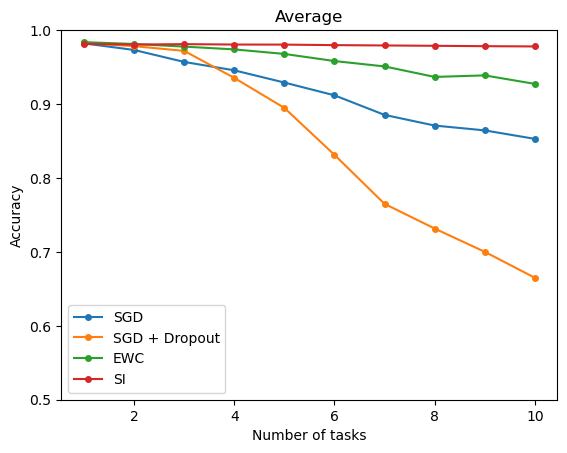

In [18]:
num_tasks = 10

# Add fig and axes
fig, ax = plt.subplots()

# Plot average accuracy
mean_acc_sgd = []
mean_acc_sgd_dropout = []
mean_acc_ewc = []
mean_acc_si = []

for i in range(1, num_tasks + 1):
    acc_sgd = 0
    acc_sgd_dropout = 0
    acc_ewc = 0
    acc_si = 0
    for j in range(1, i + 1):
        acc_sgd += acc_table_sgd[str(j)][str(i)]
        acc_sgd_dropout += acc_table_sgd_dropout[str(j)][str(i)]
        acc_ewc += acc_table_ewc[str(j)][str(i)]
        acc_si += acc_table_si[str(j)][str(i)]
    
    mean_acc_sgd.append(acc_sgd / i)
    mean_acc_sgd_dropout.append(acc_sgd_dropout / i)
    mean_acc_ewc.append(acc_ewc / i)
    mean_acc_si.append(acc_si / i)

# Plot accuracy for each task
ax.plot(np.arange(1, num_tasks + 1), mean_acc_sgd, '-o', label='SGD', lw=1.5, markersize=4)
ax.plot(np.arange(1, num_tasks + 1), mean_acc_sgd_dropout, '-o', label='SGD + Dropout', lw=1.5, markersize=4)
ax.plot(np.arange(1, num_tasks + 1), mean_acc_ewc, '-o', label='EWC', lw=1.5, markersize=4)
ax.plot(np.arange(1, num_tasks + 1), mean_acc_si, '-o', label='SI', lw=1.5, markersize=4)

ax.set_title('Average')
ax.legend()
ax.set_ylabel('Accuracy')
ax.set_xlabel('Number of tasks')
ax.set_xticks(np.arange(2, num_tasks + 1, 2))
ax.set(ylim=(0.5, 1))

plt.show()

__Discussion__
- The result with SGD + Dropout is quite surprised. Probably because we apply drop out to the input layer (you can try to see whether it improves the performance)
- SI achives higher accuracy than EWC

__Note__
- It will take you more than 8 hours if you want to run the whole notebook from scratch